读取t-shirt数据集

/mnt/ssd5/guohong/yolov3m
/mnt/ssd5/guohong/data/tshirt/train/JEPGImages/553.jpg
/mnt/ssd5/guohong/data/tshirt/train/Annotations/553.xml
[[1512  359 2177 2160]
 [ 759  548 1522 2160]] int32


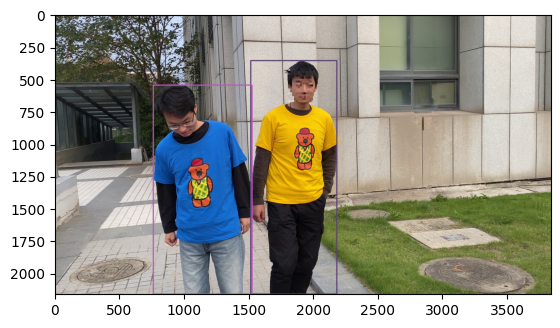

In [1]:
%reload_ext autoreload
%autoreload 2
%cd yolov3m

import random
from matplotlib import pyplot as plt
import cv2 as cv
import pathlib
import numpy as np
import xmltodict as x2d
from utils import plot_one_box

path = pathlib.Path('/mnt/ssd5/guohong/data/tshirt')

img_path = path / 'train' / 'JEPGImages'
anno_path = path / 'train' / 'Annotations'
file_names = img_path.iterdir()

for name in file_names:
    print(name)

    img = cv.imread(name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    anno_name = anno_path / str(name.stem + '.xml')
    print(anno_name)

    with open(anno_name, 'r') as f:
        data = x2d.parse(f.read())

    boxes = []
    labels = []
    for item in data['annotation']['object']:

        box = item['bndbox']
        xmin = box['xmin']
        ymin = box['ymin']
        xmax = box['xmax']
        ymax = box['ymax']
        name = item['name']
        labels.append(name)
        boxes.append([xmin, ymin, xmax, ymax])
    boxes = np.array(boxes, dtype=np.int32)

    print(boxes, boxes.dtype)

    for x in range(boxes.shape[0]):
        color = [random.randint(0,255) for _ in range(3)]
        plot_one_box(boxes[x], img, color=color)
    plt.imshow(img)
    plt.show()

    break    

T-shirt数据集的类集合

In [2]:
from collections import defaultdict
from pathlib import Path

import xmltodict as xml

path = Path('/mnt/ssd5/guohong/data/tshirt')

anno_path = path / 'train' / 'Annotations'

anno_files = anno_path.iterdir()

classes = defaultdict(bool)

for name in anno_files:
    with open(name, 'r') as f:
        data = xml.parse(f.read())['annotation']
    # print(data['filename'], end='\t')
    objs = data['object']
    if isinstance(objs, dict):
        objs = [objs]
    for item in objs:
        # print(item['name'], end='\t')
        if not(classes[item['name']]):
            classes[item['name']] = True
    # print('', end='\n')

print(classes.keys())


dict_keys(['person', 'T', 'bicycle', 'car'])


修改t-shirt数据集的xml标注文件为txt，并加到coco2014数据集中

index -- class name:
```yaml
 0: person
 1: bicycle
 2: car
```

In [ ]:
import xmltodict as xml
from pathlib import Path
import json

root = Path("/mnt/ssd5/guohong/data/tshirt/train")

anno_path = root / "Annotations"
anno_files = anno_path.iterdir()

for name in anno_files:
    with open(name, 'r') as f:
        data = xml.parse(f.read())
    print(json.dumps(data, indent=2))
    break

{
  "annotation": {
    "folder": "JPEGImages",
    "filename": "331.jpg",
    "path": "E:\\Program Files\\JetBrains\\WorkSpace\\yolo3-pytorch-master\\dataset\\JPEGImages\\331.jpg",
    "source": {
      "database": "Unknown"
    },
    "size": {
      "width": "3840",
      "height": "2160",
      "depth": "3"
    },
    "segmented": "0",
    "object": [
      {
        "name": "person",
        "pose": "Unspecified",
        "truncated": "1",
        "difficult": "0",
        "bndbox": {
          "xmin": "269",
          "ymin": "1",
          "xmax": "1472",
          "ymax": "2160"
        }
      },
      {
        "name": "T",
        "pose": "Unspecified",
        "truncated": "1",
        "difficult": "0",
        "bndbox": {
          "xmin": "1674",
          "ymin": "961",
          "xmax": "2759",
          "ymax": "2160"
        }
      }
    ]
  }
}


根据xml标准文件，制作符合coco的txt标注文件，并加入训练集

In [7]:
from pathlib import Path
import xmltodict as xml
import sys

root = Path("/mnt/ssd5/guohong/data/tshirt/train")

root_img = root / "images"
root_anno = root / "labels"

cls_index = {
    "person": 0,
    "bicycle": 1,
    "car": 2
}

anno_files = root_anno.iterdir()
img_paths = []
# anno_paths = []
for file in anno_files:
    if file.suffix != ".xml":
        continue
    print(file)
    with open(file, "r") as f:
        data = xml.parse(f.read())["annotation"]
    name = data["filename"]

    img_paths.append(root_img / name)
    anno_path = (root_anno / name).with_suffix(".txt")
    # anno_paths.append(anno_path)

    objs = data['object']
    if isinstance(objs, dict):
        objs = [objs]
    img_w, img_h = int(data["size"]["width"]), int(data["size"]["height"])
    annos = []
    for item in objs:
        cls = item["name"]
        if cls == "T":
            continue
        cls = cls_index[cls]

        box = item["bndbox"]
        xmin = int(box["xmin"])
        ymin = int(box["ymin"])
        xmax = int(box["xmax"])
        ymax = int(box["ymax"])

        w, h = xmax - xmin, ymax - ymin
        x, y = xmin + w / 2, ymin + h / 2

        w, x = w / img_w, x / img_w
        h, y = h / img_h, y / img_h
        annos.append([cls, x, y, w, h])

    with open(anno_path, 'w') as f:
        for row in annos:
            f.write("\t".join(map(str, row)) + "\n")


with open("data/coco2014/trainvalno5k.txt", "a") as f:
    for row in img_paths:
        f.write(str(row) + "\n")



/mnt/ssd5/guohong/data/tshirt/train/labels/331.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/299.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/351.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/395.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/947.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/875.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/822.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/992.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/92.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/1026.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/848.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/973.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/599.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/540.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/100.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/625.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/149.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/108.xml
/mnt/ssd5/guohong/data/tshirt/train/labels/326.xml
/mnt/ssd5/guohong/data/tshirt/t

In [10]:
from pathlib import Path

root = Path("/mnt/ssd5/guohong/data/tshirt/train")

root_img = root / "images"

print(len(list(root_img.iterdir())))

552
